In [303]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

In [140]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=r"C:\Users\Manav Patadia\Documents\Imp documents\bigqueryproject-347515-787a798db183.json"

In [141]:
def pollutant_obs(country):
    client = bigquery.Client()

    # Using WHERE reduces the amount of data scanned / quota used
    query = f"""
    SELECT pollutant, Count(pollutant) as pollutant_count_observation
    FROM `bigquery-public-data.openaq.global_air_quality`
    WHERE country='{country}'
    GROUP BY pollutant
    ORDER BY pollutant_count_observation DESC
    """

    query_job = client.query(query)

    iterator = query_job.result(timeout=30)
    rows = list(iterator)

    # Transform the rows into a nice pandas dataframe
    headlines = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

    # Look at the first 10 headlines
    print(headlines)

In [142]:
pollutant_obs('IL')
pollutant_obs('US')

  pollutant  pollutant_count_observation
0       so2                          177
1        o3                          177
2       no2                          177
3        co                          177
4      pm25                            2
  pollutant  pollutant_count_observation
0        o3                        23974
1      pm25                        21267
2      pm10                         7918
3       no2                         6007
4       so2                         5036
5        co                         3820
6        bc                          352
7        no                            1


Baisc attributes of Air quality index

Measurement units
- ug/m3 : micro gram/cubic meter
- ppm : Parts Per Million

Pollutant
- O3 : Ozone gas
- SO2 : Sulphur Dioxed
- NO2 : Nitrogen Dioxed
- PM2.5 : Particles with an aerodynamic diameter less than  2.5μm 
- PM10 : Particles with an aerodynamic diameter less than  10μm 
- CO : Carbon monoxide

In [143]:
def extract_global_air_quality():
    client = bigquery.Client()

    # Using WHERE reduces the amount of data scanned / quota used
    query = f"""SELECT * FROM `bigquery-public-data.openaq.global_air_quality`"""

    query_job = client.query(query)

    iterator = query_job.result(timeout=30)
    rows = list(iterator)

    # Transform the rows into a nice pandas dataframe
    df_global_air_quality = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
    return(df_global_air_quality)

In [146]:
def unique_gas():
    client = bigquery.Client()
    query = f"""SELECT distinct pollutant FROM `bigquery-public-data.openaq.global_air_quality`"""
    query_job = client.query(query)
    iterator = query_job.result(timeout=30)
    rows = list(iterator)
    df_pollutant = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
    print(df_pollutant)

In [147]:
unique_gas()

  pollutant
0        o3
1      pm25
2       no2
3       so2
4        co
5      pm10
6        bc
7        no


In [6]:
%%time
df_global_air_quality = extract_global_air_quality()

Wall time: 1min 13s


In [7]:
df_global_air_quality

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours,location_geom
0,MA,Salt Lake City,US,o3,0.03900,2020-01-06 18:00:00+00:00,ppm,AirNow,40.712063,-112.111120,1.000000,POINT(-112.11112 40.712063)
1,MA,Salt Lake City,US,no2,0.00300,2020-01-06 18:00:00+00:00,ppm,AirNow,40.712063,-112.111120,1.000000,POINT(-112.11112 40.712063)
2,MA,Salt Lake City,US,so2,0.00100,2020-01-06 18:00:00+00:00,ppm,AirNow,40.712063,-112.111120,1.000000,POINT(-112.11112 40.712063)
3,MA,Salt Lake City,US,pm25,1.30000,2020-01-06 18:00:00+00:00,µg/m³,AirNow,40.712063,-112.111120,1.000000,POINT(-112.11112 40.712063)
4,NR,Salt Lake City,US,co,0.00000,2020-06-11 00:00:00+00:00,ppm,AirNow,40.662840,-111.901794,1.000000,POINT(-111.901794 40.66284)
...,...,...,...,...,...,...,...,...,...,...,...,...
348494,"MED-SCRI - Medellín, San Cristobal - Parque Bi...",Medellin,CO,pm25,12.65180,2022-02-15 23:00:00+00:00,µg/m³,Medellin,1.000000,6.277850,-75.636429,POINT(6.2778502 1)
348495,"MED-VILL - Medellín, Villahermosa - Planta de ...",Medellin,CO,pm25,8.50399,2022-02-15 23:00:00+00:00,µg/m³,Medellin,1.000000,6.258909,-75.548264,POINT(6.2589092 1)
348496,"MED-UNNV - Medellín, centro occidente - Unive...",Medellin,CO,pm25,-9999.00000,2021-09-30 13:00:00+00:00,µg/m³,Medellin,1.000000,6.263370,-75.577004,POINT(6.2633696 1)
348497,"MED-UNNV - Medellín, centro occidente - Unive...",Medellin,CO,no2,-9999.00000,2021-09-30 13:00:00+00:00,ppm,Medellin,1.000000,6.263370,-75.577004,POINT(6.2633696 1)


In [8]:
df_global_air_quality.to_csv("input/global_air_quality.csv")

In [152]:
df_global_air_quality = pd.read_csv("input/global_air_quality.csv")

In [153]:
df_global_air_quality.rename(columns={'country': 'country_code2'}, inplace=True)

In [154]:
print(df_global_air_quality['timestamp'].min(), df_global_air_quality['timestamp'].max())

2007-02-09 07:00:00+00:00 2022-04-17 05:00:00+00:00


In [155]:
df_global_air_quality[df_global_air_quality['country_code2']=="IN"]

,location,city,country_code2,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours,location_geom
37,IIT,Chennai,IN,o3,19.79,2018-02-22 03:45:00+00:00,µg/m³,CPCB,12.992514,80.23745,0.2500,POINT(80.23745 12.992514)
38,IIT,Chennai,IN,pm25,70.00,2018-02-22 03:45:00+00:00,µg/m³,CPCB,12.992514,80.23745,0.2500,POINT(80.23745 12.992514)
39,IIT,Chennai,IN,so2,7.90,2018-02-22 03:45:00+00:00,µg/m³,CPCB,12.992514,80.23745,0.2500,POINT(80.23745 12.992514)
40,IIT,Chennai,IN,no2,6.13,2018-02-22 03:45:00+00:00,µg/m³,CPCB,12.992514,80.23745,0.2500,POINT(80.23745 12.992514)
41,IIT,Chennai,IN,co,850.00,2018-02-22 03:45:00+00:00,µg/m³,CPCB,12.992514,80.23745,0.2500,POINT(80.23745 12.992514)
...,...,...,...,...,...,...,...,...,...,...,...,...
348208,"Punjab Agricultural University, Ludhiana - PPCB",Ludhiana,IN,pm10,215.87,2022-04-14 04:00:00+00:00,µg/m³,caaqm,1.000000,30.90280,75.8086,POINT(30.9028 1)
348209,"Punjab Agricultural University, Ludhiana - PPCB",Ludhiana,IN,pm25,88.15,2022-04-10 04:00:00+00:00,µg/m³,caaqm,1.000000,30.90280,75.8086,POINT(30.9028 1)
348210,"Punjab Agricultural University, Ludhiana - PPCB",Ludhiana,IN,co,1450.00,2022-04-02 04:00:00+00:00,µg/m³,caaqm,1.000000,30.90280,75.8086,POINT(30.9028 1)
348211,"Punjab Agricultural University, Ludhiana - PPCB",Ludhiana,IN,o3,62.85,2022-03-30 04:00:00+00:00,µg/m³,caaqm,1.000000,30.90280,75.8086,POINT(30.9028 1)


In [156]:
len(df_global_air_quality['country_code2'].unique())

111

In [157]:
df_global_air_quality = df_global_air_quality[["city", "country_code2", "pollutant", "value", "timestamp", "unit"]]

In [158]:
df_global_air_quality['timestamp'] =  pd.to_datetime(df_global_air_quality['timestamp']).dt.strftime('%Y')
df_global_air_quality['timestamp'] =  pd.to_datetime(df_global_air_quality['timestamp']).map(lambda x: x.year)
df_global_air_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348499 entries, 0 to 348498
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   city           344938 non-null  object 
 1   country_code2  348499 non-null  object 
 2   pollutant      348499 non-null  object 
 3   value          348499 non-null  float64
 4   timestamp      348499 non-null  int64  
 5   unit           348499 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 16.0+ MB


In [159]:
df_global_air_quality

,city,country_code2,pollutant,value,timestamp,unit
0,Salt Lake City,US,so2,0.00100,2020,ppm
1,Salt Lake City,US,o3,0.03900,2020,ppm
2,Salt Lake City,US,pm25,1.30000,2020,µg/m³
3,Salt Lake City,US,no2,0.00300,2020,ppm
4,Salt Lake City,US,o3,0.04300,2020,ppm
...,...,...,...,...,...,...
348494,Medellin,CO,pm25,12.65180,2022,µg/m³
348495,Medellin,CO,pm25,8.50399,2022,µg/m³
348496,Medellin,CO,pm25,-9999.00000,2021,µg/m³
348497,Medellin,CO,o3,-9999.00000,2021,ppm


In [160]:
df_pivot_global_air_quality = pd.pivot_table(df_global_air_quality, values = 'value', index=['country_code2','timestamp'], columns = 'pollutant').reset_index()
df_pivot_global_air_quality

pollutant,country_code2,timestamp,bc,co,no,no2,o3,pm10,pm25,so2
0,AD,2020,NaN,100.000000,NaN,3.000000,59.333333,4.000000,NaN,2.000000
1,AD,2021,NaN,NaN,NaN,NaN,81.000000,NaN,NaN,NaN
2,AD,2022,NaN,126.315789,NaN,6.315789,69.026316,15.368421,NaN,0.105263
3,AE,2020,NaN,NaN,NaN,NaN,0.008667,NaN,24.333333,NaN
4,AE,2021,NaN,NaN,NaN,NaN,-0.240750,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
372,XK,2022,NaN,NaN,NaN,NaN,NaN,NaN,-31.105263,NaN
373,ZA,2019,NaN,NaN,NaN,NaN,NaN,8.333333,NaN,0.000060
374,ZA,2020,NaN,0.470000,NaN,0.027000,NaN,13.500000,7.400000,NaN
375,ZA,2021,NaN,0.876917,NaN,-0.005377,0.016267,30.152235,5.631621,0.008449


In [161]:
df_pivot_global_air_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_code2  377 non-null    object 
 1   timestamp      377 non-null    int64  
 2   bc             10 non-null     float64
 3   co             187 non-null    float64
 4   no             1 non-null      float64
 5   no2            231 non-null    float64
 6   o3             219 non-null    float64
 7   pm10           218 non-null    float64
 8   pm25           297 non-null    float64
 9   so2            196 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 29.6+ KB


In [162]:
df_group = df_pivot_global_air_quality.groupby(["country_code2", "timestamp"]).agg({'co': np.mean,
                                                                              'no2': np.mean,
                                                                              'o3': np.mean,
                                                                              'pm10': np.mean,
                                                                              'pm25': np.mean,
                                                                              'so2': np.mean})

In [163]:
df_group.reset_index(inplace=True)
df_group

pollutant,country_code2,timestamp,co,no2,o3,pm10,pm25,so2
0,AD,2020,100.000000,3.000000,59.333333,4.000000,NaN,2.000000
1,AD,2021,NaN,NaN,81.000000,NaN,NaN,NaN
2,AD,2022,126.315789,6.315789,69.026316,15.368421,NaN,0.105263
3,AE,2020,NaN,NaN,0.008667,NaN,24.333333,NaN
4,AE,2021,NaN,NaN,-0.240750,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
372,XK,2022,NaN,NaN,NaN,NaN,-31.105263,NaN
373,ZA,2019,NaN,NaN,NaN,8.333333,NaN,0.000060
374,ZA,2020,0.470000,0.027000,NaN,13.500000,7.400000,NaN
375,ZA,2021,0.876917,-0.005377,0.016267,30.152235,5.631621,0.008449


In [166]:
df_country_codes = pd.read_csv("input/country_codes.csv")
df_country_codes = df_country_codes[["Country", "Alpha-2 code", "Alpha-3 code","Numeric"]]
df_country_codes.columns = ["country_name", "country_code2", "country_code3", "Numeric_code"]
df_country_codes

,country_name,country_code2,country_code3,Numeric_code
0,Afghanistan,AF,AFG,4
1,Albania,AL,ALB,8
2,Algeria,DZ,DZA,12
3,American Samoa,AS,ASM,16
4,Andorra,AD,AND,20
...,...,...,...,...
244,Western Sahara,EH,ESH,732
245,Yemen,YE,YEM,887
246,Zambia,ZM,ZMB,894
247,Zimbabwe,ZW,ZWE,716


In [167]:
df_new = pd.merge(df_group, df_country_codes, how='left', on=['country_code2'])
df_new = df_new[["Numeric_code", "country_name","country_code3", "country_code2", "timestamp", "co", "no2", "o3", "pm10", "pm25", "so2"]]
df_new = df_new[~df_new["country_code3"].isna()]
df_new

,Numeric_code,country_name,country_code3,country_code2,timestamp,co,no2,o3,pm10,pm25,so2
0,20.0,Andorra,AND,AD,2020,100.000000,3.000000,59.333333,4.000000,NaN,2.000000
1,20.0,Andorra,AND,AD,2021,NaN,NaN,81.000000,NaN,NaN,NaN
2,20.0,Andorra,AND,AD,2022,126.315789,6.315789,69.026316,15.368421,NaN,0.105263
3,784.0,United Arab Emirates (the),ARE,AE,2020,NaN,NaN,0.008667,NaN,24.333333,NaN
4,784.0,United Arab Emirates (the),ARE,AE,2021,NaN,NaN,-0.240750,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
369,704.0,Viet Nam,VNM,VN,2022,NaN,NaN,NaN,NaN,-526.648649,NaN
373,710.0,South Africa,ZAF,ZA,2019,NaN,NaN,NaN,8.333333,NaN,0.000060
374,710.0,South Africa,ZAF,ZA,2020,0.470000,0.027000,NaN,13.500000,7.400000,NaN
375,710.0,South Africa,ZAF,ZA,2021,0.876917,-0.005377,0.016267,30.152235,5.631621,0.008449


In [168]:
df_death_pollution = pd.read_csv("input/death-rate-from-air-pollution-per-100000.csv")
df_death_pollution.drop("Entity", axis = 1, inplace = True)
df_death_pollution.columns = ["country_code3", "timestamp", "death_rate"]
df_death_pollution

,country_code3,timestamp,death_rate
0,AFG,1990,402.175651
1,AFG,1991,390.085258
2,AFG,1992,383.201196
3,AFG,1993,387.704919
4,AFG,1994,394.022027
...,...,...,...
8005,ZWE,2015,183.044625
8006,ZWE,2016,179.060638
8007,ZWE,2017,174.048806
8008,ZWE,2018,169.534057


In [169]:
len(df_death_pollution['country_code3'].unique())

206

In [170]:
print(df_death_pollution['timestamp'].min(), df_death_pollution['timestamp'].max())

1990 2019


In [171]:
print(df_new['timestamp'].min(), df_new['timestamp'].max())

2007 2022


In [172]:
df_final = pd.merge(df_new, df_death_pollution, how='left', on=['country_code3','timestamp'])
df_final

,Numeric_code,country_name,country_code3,country_code2,timestamp,co,no2,o3,pm10,pm25,so2,death_rate
0,20.0,Andorra,AND,AD,2020,100.000000,3.000000,59.333333,4.000000,NaN,2.000000,NaN
1,20.0,Andorra,AND,AD,2021,NaN,NaN,81.000000,NaN,NaN,NaN,NaN
2,20.0,Andorra,AND,AD,2022,126.315789,6.315789,69.026316,15.368421,NaN,0.105263,NaN
3,784.0,United Arab Emirates (the),ARE,AE,2020,NaN,NaN,0.008667,NaN,24.333333,NaN,NaN
4,784.0,United Arab Emirates (the),ARE,AE,2021,NaN,NaN,-0.240750,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
351,704.0,Viet Nam,VNM,VN,2022,NaN,NaN,NaN,NaN,-526.648649,NaN,NaN
352,710.0,South Africa,ZAF,ZA,2019,NaN,NaN,NaN,8.333333,NaN,0.000060,72.759472
353,710.0,South Africa,ZAF,ZA,2020,0.470000,0.027000,NaN,13.500000,7.400000,NaN,NaN
354,710.0,South Africa,ZAF,ZA,2021,0.876917,-0.005377,0.016267,30.152235,5.631621,0.008449,NaN


In [173]:
df_final = df_final[~df_final["death_rate"].isna()].reset_index()

In [174]:
df_final

,index,Numeric_code,country_name,country_code3,country_code2,timestamp,co,no2,o3,pm10,pm25,so2,death_rate
0,8,32.0,Argentina,ARG,AR,2015,NaN,NaN,NaN,NaN,18.100000,NaN,27.685235
1,9,32.0,Argentina,ARG,AR,2017,0.390000,0.014333,NaN,15.666667,NaN,NaN,26.406915
2,11,40.0,Austria,AUT,AT,2016,482.818182,33.383085,39.639706,19.675159,NaN,2.873563,14.529572
3,12,40.0,Austria,AUT,AT,2017,104.417646,12.934065,84.586441,15.200936,NaN,1.730320,13.408647
4,16,36.0,Australia,AUS,AU,2016,0.100000,0.002400,0.008000,NaN,NaN,0.206000,4.277294
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,340,840.0,United States of America (the),USA,US,2018,0.348966,0.008846,0.023837,15.710526,12.440385,-35.832419,10.588970
132,341,840.0,United States of America (the),USA,US,2019,0.359333,0.007649,0.033100,17.844828,9.231034,0.000176,10.551644
133,348,704.0,Viet Nam,VNM,VN,2015,NaN,NaN,NaN,NaN,36.900000,NaN,99.364197
134,349,704.0,Viet Nam,VNM,VN,2016,NaN,NaN,NaN,NaN,20.550000,NaN,95.333725


In [175]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          136 non-null    int64  
 1   Numeric_code   136 non-null    float64
 2   country_name   136 non-null    object 
 3   country_code3  136 non-null    object 
 4   country_code2  136 non-null    object 
 5   timestamp      136 non-null    int64  
 6   co             71 non-null     float64
 7   no2            98 non-null     float64
 8   o3             79 non-null     float64
 9   pm10           91 non-null     float64
 10  pm25           89 non-null     float64
 11  so2            72 non-null     float64
 12  death_rate     136 non-null    float64
dtypes: float64(8), int64(2), object(3)
memory usage: 13.9+ KB


In [176]:
print(df_final['timestamp'].min(), df_final['timestamp'].max())

2007 2019


In [177]:
df_final.to_csv("input/pollution_death_2007_2019.csv", index = False)

In [280]:
df_final = pd.read_csv("input/pollution_death_2007_2019.csv")

In [281]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          136 non-null    int64  
 1   Numeric_code   136 non-null    float64
 2   country_name   136 non-null    object 
 3   country_code3  136 non-null    object 
 4   country_code2  136 non-null    object 
 5   timestamp      136 non-null    int64  
 6   co             71 non-null     float64
 7   no2            98 non-null     float64
 8   o3             79 non-null     float64
 9   pm10           91 non-null     float64
 10  pm25           89 non-null     float64
 11  so2            72 non-null     float64
 12  death_rate     136 non-null    float64
dtypes: float64(8), int64(2), object(3)
memory usage: 13.9+ KB


In [282]:
len(df_final['country_code3'].unique())

53

In [283]:
print(df_final['timestamp'].min(), df_final['timestamp'].max())

2007 2019


In [284]:
print(df_final['death_rate'].min(), df_final['death_rate'].max())

2.6605287755401235 190.4566270570091


In [309]:
def death_rate_group(rate):
    return int(rate / 50)

In [310]:
df_final['death_rate_group'] = df_final['death_rate'].apply(death_rate_group)

In [403]:
df_final[df_final['country_code3'] == 'IND']

,index,Numeric_code,country_name,country_code3,country_code2,timestamp,co,no2,o3,pm10,pm25,so2,death_rate,death_rate_group
69,179,356.0,India,IND,IN,2014,NaN,NaN,NaN,NaN,27.800000,NaN,185.811026,3
70,180,356.0,India,IND,IN,2015,1620.000000,68.235000,31.830000,342.560000,52.905000,NaN,179.745940,3
71,181,356.0,India,IND,IN,2016,695.000000,NaN,13.086667,132.940000,115.857143,NaN,171.955300,3
72,182,356.0,India,IND,IN,2017,1600.130714,59.320000,56.140000,166.998333,57.000000,27.052308,167.037291,3
73,183,356.0,India,IND,IN,2018,4293.567123,59.994286,55.053968,280.808600,141.475200,13.451579,167.216992,3
74,184,356.0,India,IND,IN,2019,429.000000,10.678750,22.678000,37.705714,37.867500,8.232857,164.078680,3


In [312]:
print(df_final['death_rate_group'].min(), df_final['death_rate_group'].max())

0 3


In [313]:
df_death_rate = df_final[["Numeric_code", "country_code3", "timestamp", "co", "no2", "o3", "pm10", "pm25", "so2", "death_rate", "death_rate_group"]]

In [314]:
df_death_rate = df_death_rate.fillna(0)
df_death_rate['Numeric_code'] = df_death_rate['Numeric_code'].astype('int')
df_death_rate.rename(columns={'timestamp': 'year'}, inplace=True)

In [315]:
df_death_rate

,Numeric_code,country_code3,year,co,no2,o3,pm10,pm25,so2,death_rate,death_rate_group
0,32,ARG,2015,0.000000,0.000000,0.000000,0.000000,18.100000,0.000000,27.685235,0
1,32,ARG,2017,0.390000,0.014333,0.000000,15.666667,0.000000,0.000000,26.406915,0
2,40,AUT,2016,482.818182,33.383085,39.639706,19.675159,0.000000,2.873563,14.529572,0
3,40,AUT,2017,104.417646,12.934065,84.586441,15.200936,0.000000,1.730320,13.408647,0
4,36,AUS,2016,0.100000,0.002400,0.008000,0.000000,0.000000,0.206000,4.277294,0
...,...,...,...,...,...,...,...,...,...,...,...
131,840,USA,2018,0.348966,0.008846,0.023837,15.710526,12.440385,-35.832419,10.588970,0
132,840,USA,2019,0.359333,0.007649,0.033100,17.844828,9.231034,0.000176,10.551644,0
133,704,VNM,2015,0.000000,0.000000,0.000000,0.000000,36.900000,0.000000,99.364197,1
134,704,VNM,2016,0.000000,0.000000,0.000000,0.000000,20.550000,0.000000,95.333725,1


In [316]:
df_death_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Numeric_code      136 non-null    int32  
 1   country_code3     136 non-null    object 
 2   year              136 non-null    int64  
 3   co                136 non-null    float64
 4   no2               136 non-null    float64
 5   o3                136 non-null    float64
 6   pm10              136 non-null    float64
 7   pm25              136 non-null    float64
 8   so2               136 non-null    float64
 9   death_rate        136 non-null    float64
 10  death_rate_group  136 non-null    int64  
dtypes: float64(7), int32(1), int64(2), object(1)
memory usage: 11.3+ KB


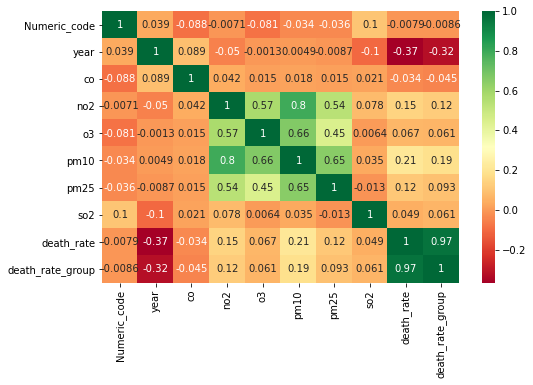

In [317]:
plt.subplots(figsize=(8, 5))
sns.heatmap(df_death_rate.corr(), annot=True, cmap="RdYlGn")
plt.show()

In [378]:
X = df_death_rate[['Numeric_code', 'year', 'co', 'no2', 'o3', 'pm10', 'pm25']] #
y = df_death_rate['death_rate_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle = True)

In [379]:
labels = list(y.unique()).sort()

In [380]:
def evaluate_model(X_train, y_train, X_valid, y_valid, classes, model, model_name):
    divider = "-"*120
    print(divider)
    model.fit(X_train, y_train)
    model, score = print_accuracy(X_train, y_train, X_valid, y_valid, classes, model, model_name)
    return model, score

In [389]:
def print_accuracy(X_train, y_train, X_valid, y_valid, classes, model, model_name):
    divider = "-"*120
    predicted = model.predict(X_valid)
    train_acc_scr = model.score(X_train, y_train)
    print("Train Accuracy Score of "+model_name+" model is:\n", train_acc_scr)
    print(divider)
    val_acc_scr = model.score(X_valid, y_valid)
    print("Test Accuracy Score of "+model_name+" model is:\n", val_acc_scr)
    print(divider)
    get_cross_val(model, X_train, y_train, X_test, y_test)
    print(divider)
    confusion_mat = confusion_matrix(y_true=y_valid, y_pred=predicted)
    print("Confusion Matrix:")
    print(confusion_mat)
    sns.heatmap(confusion_mat, annot=True,fmt="d",cmap=plt.cm.Accent)
    plt.title('Confusion Matrix of '+model_name+' Model', fontsize = 20)
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.show()
    print(classes)
    print(divider)
    pprint(classification_report(y_valid, predicted))
    return model, [train_acc_scr, val_acc_scr]

In [394]:
def get_cross_val(model, X_train, y_train, X_test, y_test):
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    print("Cross validation over 10 folds: ", sum(scores)/10.0)

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Multinomial Logistic Regression model is:
 0.8148148148148148
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of Multinomial Logistic Regression model is:
 0.6428571428571429
------------------------------------------------------------------------------------------------------------------------
Cross validation over 10 folds:  0.7245454545454547
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[17  1  0  0]
 [ 2  0  0  0]
 [ 4  0  0  0]
 [ 3  0  0  1]]


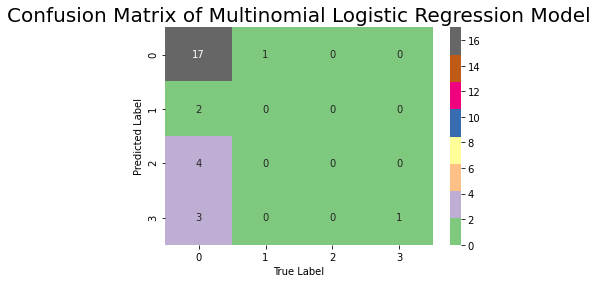

None
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.65      0.94      0.77        18\n'
 '           1       0.00      0.00      0.00         2\n'
 '           2       0.00      0.00      0.00         4\n'
 '           3       1.00      0.25      0.40         4\n'
 '\n'
 '    accuracy                           0.64        28\n'
 '   macro avg       0.41      0.30      0.29        28\n'
 'weighted avg       0.56      0.64      0.55        28\n')


In [395]:
# check classification scores of logistic regression
logreg_model = LogisticRegression(multi_class='multinomial', max_iter=10000)
logreg_model, score_lr = evaluate_model(X_train, y_train, X_test, y_test, labels, logreg_model, "Multinomial Logistic Regression")

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of XGB Classifier model is:
 1.0
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of XGB Classifier model is:
 0.7142857142857143
------------------------------------------------------------------------------------------------------------------------
Cross validation over 10 folds:  0.7681818181818183
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[17  0  1  0]
 [ 2  0  0  0]
 [ 2  0  1  1]
 [ 2  0  0  2]]


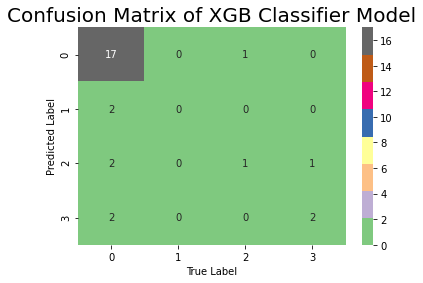

None
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.74      0.94      0.83        18\n'
 '           1       0.00      0.00      0.00         2\n'
 '           2       0.50      0.25      0.33         4\n'
 '           3       0.67      0.50      0.57         4\n'
 '\n'
 '    accuracy                           0.71        28\n'
 '   macro avg       0.48      0.42      0.43        28\n'
 'weighted avg       0.64      0.71      0.66        28\n')
Wall time: 2.48 s


In [396]:
%%time
xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc')
xgb_model, score_xgb = evaluate_model(X_train, y_train, X_test, y_test, labels, xgb_model, "XGB Classifier")

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Support Vector Classifier model is:
 0.7592592592592593
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of Support Vector Classifier model is:
 0.6428571428571429
------------------------------------------------------------------------------------------------------------------------
Cross validation over 10 folds:  0.76
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[18  0  0  0]
 [ 2  0  0  0]
 [ 4  0  0  0]
 [ 4  0  0  0]]


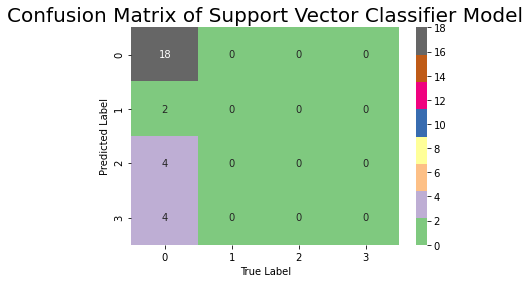

None
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.64      1.00      0.78        18\n'
 '           1       0.00      0.00      0.00         2\n'
 '           2       0.00      0.00      0.00         4\n'
 '           3       0.00      0.00      0.00         4\n'
 '\n'
 '    accuracy                           0.64        28\n'
 '   macro avg       0.16      0.25      0.20        28\n'
 'weighted avg       0.41      0.64      0.50        28\n')
Wall time: 605 ms


In [397]:
%%time
svc_model = SVC(kernel='rbf')
svc_model, score_svc = evaluate_model(X_train, y_train, X_test, y_test, labels, svc_model, "Support Vector Classifier")

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of K-Nearest Neighbor(KNN) model is:
 0.7870370370370371
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of K-Nearest Neighbor(KNN) model is:
 0.6785714285714286
------------------------------------------------------------------------------------------------------------------------
Cross validation over 10 folds:  0.7318181818181818
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[18  0  0  0]
 [ 2  0  0  0]
 [ 3  1  0  0]
 [ 3  0  0  1]]


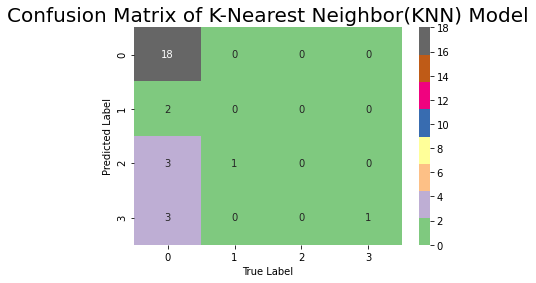

None
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.69      1.00      0.82        18\n'
 '           1       0.00      0.00      0.00         2\n'
 '           2       0.00      0.00      0.00         4\n'
 '           3       1.00      0.25      0.40         4\n'
 '\n'
 '    accuracy                           0.68        28\n'
 '   macro avg       0.42      0.31      0.30        28\n'
 'weighted avg       0.59      0.68      0.58        28\n')
Wall time: 439 ms


In [398]:
%%time
knn_model = KNeighborsClassifier(5)
knn_model, score_we_knn = evaluate_model(X_train, y_train, X_test, y_test, labels, knn_model, "K-Nearest Neighbor(KNN)")

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Random Forest Classifier model is:
 1.0
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of Random Forest Classifier model is:
 0.7142857142857143
------------------------------------------------------------------------------------------------------------------------
Cross validation over 10 folds:  0.7418181818181819
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[18  0  0  0]
 [ 2  0  0  0]
 [ 3  0  0  1]
 [ 2  0  0  2]]


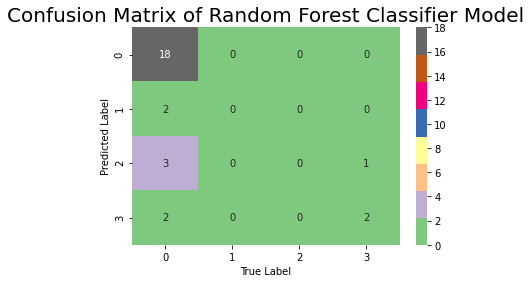

None
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.72      1.00      0.84        18\n'
 '           1       0.00      0.00      0.00         2\n'
 '           2       0.00      0.00      0.00         4\n'
 '           3       0.67      0.50      0.57         4\n'
 '\n'
 '    accuracy                           0.71        28\n'
 '   macro avg       0.35      0.38      0.35        28\n'
 'weighted avg       0.56      0.71      0.62        28\n')
Wall time: 4.07 s


In [399]:
%%time
rndm_frst_model = RandomForestClassifier(n_estimators=200)
rndm_frst_model, score_rfc = evaluate_model(X_train, y_train, X_test, y_test, labels, rndm_frst_model, "Random Forest Classifier")

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Multinomial Naive Bayes model is:
 0.7592592592592593
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of Multinomial Naive Bayes model is:
 0.6428571428571429
------------------------------------------------------------------------------------------------------------------------
Cross validation over 10 folds:  0.76
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[18  0  0  0]
 [ 2  0  0  0]
 [ 4  0  0  0]
 [ 4  0  0  0]]


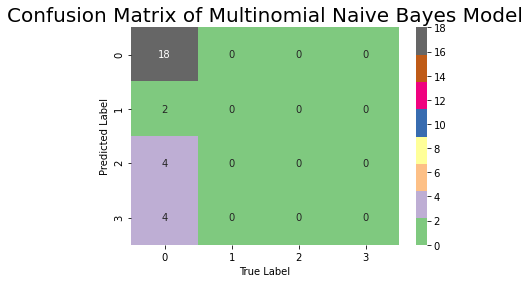

None
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.64      1.00      0.78        18\n'
 '           1       0.00      0.00      0.00         2\n'
 '           2       0.00      0.00      0.00         4\n'
 '           3       0.00      0.00      0.00         4\n'
 '\n'
 '    accuracy                           0.64        28\n'
 '   macro avg       0.16      0.25      0.20        28\n'
 'weighted avg       0.41      0.64      0.50        28\n')
Wall time: 486 ms
Wall time: 486 ms


In [400]:
%%time
min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)
multi_naive_bayes_model = MultinomialNB()
multi_naive_bayes_model, score_mnb = evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, labels, multi_naive_bayes_model, "Multinomial Naive Bayes")

In [ ]:
'''import netCDF4
precip_nc_file = r'C:\spark\MCA\Semester1\E2_BA\Climate_Change_Land_Ocean_Case_Study\input\extra\timeseries-tas-annual-mean_cru_annual_cru-ts4.05-timeseries_mean_1901-2020.nc'
nc = netCDF4.Dataset(precip_nc_file, mode='r')
cols = list(nc.variables.keys())
list_nc = []
for c in cols:
    list_nc.append(list(nc.variables[c][:]))
df_nc = pd.DataFrame(list_nc)
df_nc = df_nc.T
df_nc.columns = cols'''